# CNN-Challenge-A: particle image classifier

# Example training

This notebook shows an example of a network training. We use a CNN model called ResNet and train for 100,000 iterations.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Particle Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [5]:
from cnn_challenge_a import ParticleImage2D
datapath='/sdf/group/neutrino/kterao/data/kmi2020/image_classification/train.h5'
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [7]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.5, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from cnn_challenge_a import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

## Challenge

Here are open-ended challenge project for an image classification.

* Design a machine learning algorithm for performing image classification task. Report the performance (speed, memory, and classification accuracy) you achieved on the test set (remember, use the test set to only benchmark, don't use it for hyper parameter tuning nor training the model!). You might just train very long time, modify the network architecture, or come up with a better training strategy. Let us know what you tried and found!

If you want more guidance, you could try the steps below. But stay open minded and try what you think interesting!

1. Write a python script that trains your model for 70,000 steps using 90% of training sample. Store the network weights every 2500 steps. 

2. Use 10% of training sample as a validation set. Quantify the performance (loss and accuracy) on the stored weights (at every 2500 steps) by running the network inference on the full validation set. You can do this after training is over, or while you are training the network.

3. Look for features in mistakes made by the network. When is it hard for the network to identify a particle? Can you engineer variables to guide this search (e.g. number of pixel count per image v.s. softmax score, average pixel value, etc.)?

4. Play with the network architecture. For instance, if you designed a CNN, could you implement a residual connection? How does that affect the speed and performance of your network?

5. Can we speed-up the network (training time and/or inference time)? What's the trade-off with its performance on the task (i.e. accuracy)? 

In [9]:
! mkdir -p weights_a

In [10]:
from resnet import ResNet

class BLOB:
    pass
blob=BLOB()
blob.device    = device # GPU or CPU
blob.net       = ResNet(10,1,16,[2,2,2,2,2]).to(blob.device) # construct the network, set to the right device
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# Import train_loop, plot_loss
from utils import train_loop, plot_loss, save_state
blob.weight_file=save_state(blob,prefix='./weights_a/ResNet')
# Train
steps  = [(i+1)*10    for i in range(9)]
steps += [(i+1)*100   for i in range(9)]
steps += [(i+1)*1000  for i in range(9)]
steps += [(i+1)*10000 for i in range(9)]

loss,acc=[],[]
for step in steps[1:]:
    train_result=train_loop(blob,train_loader,num_iteration=step)
    loss.append(train_result['loss'])
    blob.weight_file=save_state(blob,prefix='./weights_a/ResNet')
    np.savez('train_log_a.npz', loss=np.hstack(loss))

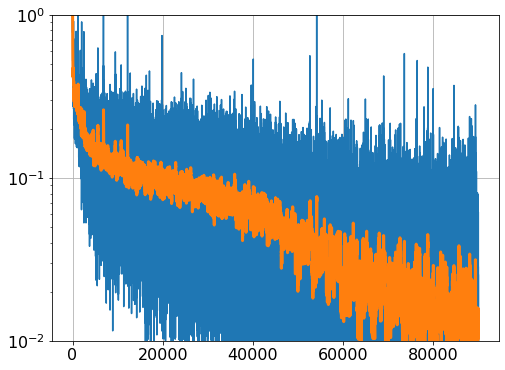

In [16]:
from utils import moving_average

f=np.load('train_log_a.npz')

plt.plot(f['loss'],label='loss')
plt.plot(*moving_average(f['loss'],40),label='average (40 pts)',linewidth=3)
plt.ylim(0.01,1.)
plt.yscale('log')
plt.show()